##### Thank you for opening this Kernel! 

### I'll be doing some simple data exploration and then make a simple sentiment analysis model that can be used to predict reviews.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from textblob.classifiers import NaiveBayesClassifier
from sklearn.metrics import confusion_matrix
import re
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#pip install seaborn

In [3]:
# load the dataset and take a look at the first few records
df = pd.read_csv('London_hotel_reviews.csv', encoding = "ISO-8859-1")
print(df.shape)
df.head()

(27331, 6)


,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
0,Apex London Wall Hotel,5.0,Ottima qualità prezzo,Siamo stati a Londra per un week end ed abbiam...,"Casale Monferrato, Italy",10/20/2012
1,Corinthia Hotel London,5.0,"By far, my best hotel in the world",I had a pleasure of staying in this hotel for ...,"Savannah, Georgia",3/23/2016
2,The Savoy,5.0,First visit to the American Bar at the Savoy,A very lovely first visit to this iconic hotel...,London,7/30/2013
3,Rhodes Hotel,4.0,Nice stay,3 of us stayed at the Rhodes Hotel for 4 night...,"Maui, Hawaii",6/2/2012
4,The Savoy,5.0,Perfection,Form the moment we arrived until we left we ex...,"London, United Kingdom",11/24/2017


This is a pretty straightforward dataset of 27,330 rows, each representing an individual review of some hotel. First I'll check if there are any NaN values and display some of them. 

In [4]:
print(df.isna().sum(), end = '\n\n')
df[df.isnull().any(axis=1)].head()

Property Name                  1
Review Rating                  1
Review Title                   1
Review Text                    1
Location Of The Reviewer    3954
Date Of Review                 2
dtype: int64



,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
5,Corinthia Hotel London,1.0,Staff stole from me!!,Well I am no strange to London's 5star hotels ...,NaN,3/1/2013
24,Mondrian London at Sea Containers,5.0,"Fantastic nights stay, one of the best hotels ...",My partner and I found this hotel by chance an...,NaN,6/20/2015
34,Mondrian London at Sea Containers,5.0,Just as good second time around!,After an amazing experience the first time we ...,NaN,10/15/2015
37,The Rembrandt,5.0,Good Hotel - Great Area,Very good hotel in a lovely area. Handy to the...,NaN,11/4/2016
45,Apex London Wall Hotel,4.0,Eccellente,"In tutto, dalla struttura nuova in stile moder...",NaN,4/30/2013


The "Location Of The Reviewer" column has a large number of NaN values, with the "Date Of Review" column containing just one. We can take a look at that.

In [5]:
df[df["Date Of Review"].isnull()]

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review
6556,The Lanesborough,4.0,<U+0412> <U+043F><U+043E><U+0434><U+0440><U+04...,<U+041E><U+0442><U+0435><U+043B><U+044C> : | <...,NaN,NaN
6557,NaN,NaN,NaN,NaN,NaN,NaN


Something wrong there - probably the review was written in a different language and the characters couldn't be displayed. I'll check if there are others like it.

In [6]:
print(len(df[df['Review Title'].str.contains("<U")]), 'reviews that are probably gibberish.')
df[df['Review Title'].str.contains("<U")].head()

ValueError: cannot index with vector containing NA / NaN values

These can be removed.

In [7]:
df = df[df['Review Title'].str.contains("<U") == False]

Now a few graphs to visualize some of the data.

[Text(0, 0, 'The Savoy'),
 Text(0, 0, 'Mondrian London at Sea Containers'),
 Text(0, 0, 'The Rembrandt'),
 Text(0, 0, 'Corinthia Hotel London'),
 Text(0, 0, 'Apex London Wall Hotel'),
 Text(0, 0, 'The Dorchester'),
 Text(0, 0, 'Rhodes Hotel'),
 Text(0, 0, 'Hotel Xenia, Autograph Collection'),
 Text(0, 0, 'Ridgemount Hotel'),
 Text(0, 0, 'Mandarin Oriental Hyde Park, London'),
 Text(0, 0, 'Bulgari Hotel, London'),
 Text(0, 0, 'The Wellesley Knightsbridge, a Luxury Collection Hotel, London'),
 Text(0, 0, 'The Lanesborough'),
 Text(0, 0, 'London Guest House'),
 Text(0, 0, 'Newham Hotel'),
 Text(0, 0, 'A To Z Hotel'),
 Text(0, 0, '45 Park Lane - Dorchester Collection'),
 Text(0, 0, 'Hartley Hotel'),
 Text(0, 0, 'Marble Arch Hotel'),
 Text(0, 0, 'City View Hotel')]

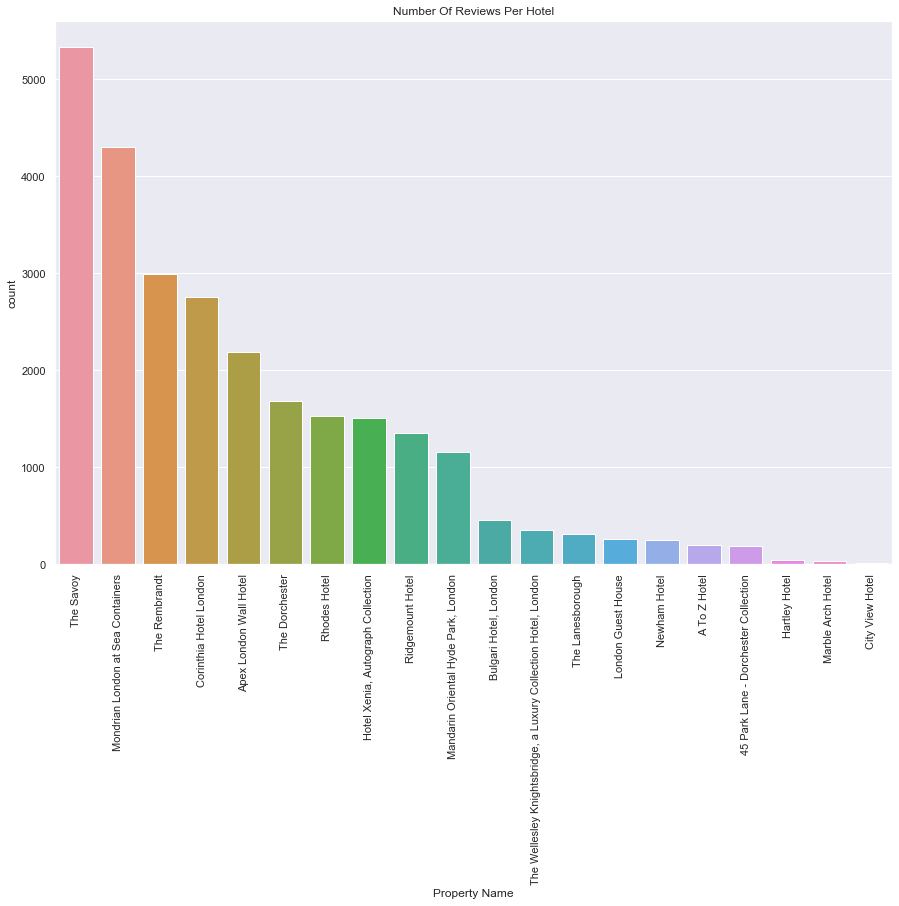

In [8]:
sns.set(rc={'figure.figsize':(15,10)}) # this will set the size of all the following graphs (default is too small)
grid = sb.countplot(x = 'Property Name', data = df, order = df['Property Name'].value_counts().index)
grid.set_title('Number Of Reviews Per Hotel')
grid.set_xticklabels(grid.get_xticklabels(), rotation=90)

Text(0.5, 1.0, 'Number Of Ratings')

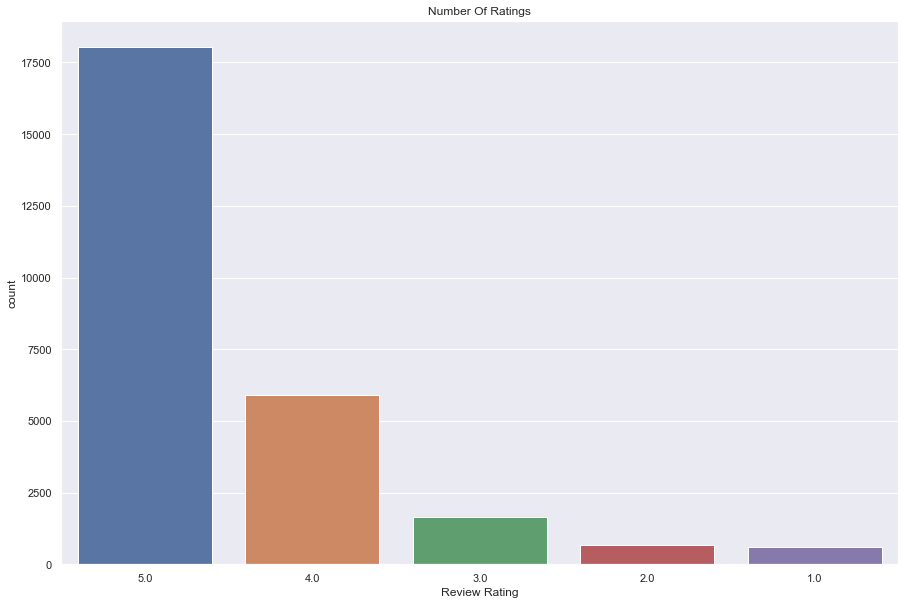

In [9]:
grid = sb.countplot(x = 'Review Rating', data = df, order = df['Review Rating'].value_counts().index)
grid.set_title('Number Of Ratings')

What about the average rating for each hotel? To do this I'll make a new dataframe with two columns ("Property Name" and "Average Rating"), calculate the average rating of each hotel, and then add each hotel name and its average rating to the dataframe. A dataframe can be displayed as a graph very easily.

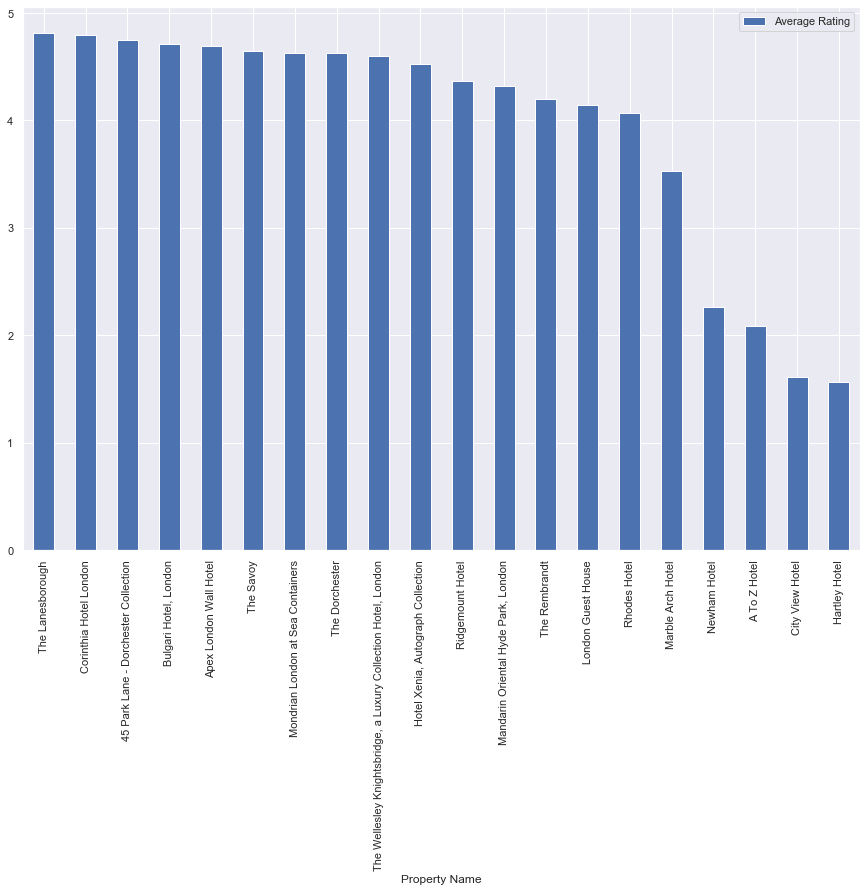

In [10]:
# get average review rating for each hotel
average_rating_df = pd.DataFrame(columns = ['Property Name', 'Average Rating'])
count = 0
for i in df['Property Name'].unique():
    average_rating = sum(df['Review Rating'][df['Property Name'] == i]) / sum(df['Property Name'] == i)
    average_rating_df.loc[count] = [i, average_rating]
    count += 1 
average_rating_df = average_rating_df.sort_values('Average Rating', ascending = False)
average_rating_df.plot(kind = 'bar', x = 'Property Name')

So the majority of hotels here are very good, with a handful of very bad ones. The next graph I'll make is a count of the locations of reviewers. Looking at the "Location Of The Reviewer" column, many entries are of the pattern (city), (country) eg. "London, United Kingdom" (though for US locations it'll be (city), (state) like "Broomfield, Colorado"). To return countries I'll make a new column that is everything after the last comma (,) if there is a comma in the location of the reviewer. Then I'll display the most common 20 locations.

[Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'NA'),
 Text(0, 0, 'Italy'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Australia'),
 Text(0, 0, 'France'),
 Text(0, 0, 'London'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Canada'),
 Text(0, 0, 'Germany'),
 Text(0, 0, 'Switzerland'),
 Text(0, 0, 'UK'),
 Text(0, 0, 'Spain'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'Ireland'),
 Text(0, 0, 'England'),
 Text(0, 0, 'Sweden'),
 Text(0, 0, 'Belgium'),
 Text(0, 0, 'The Netherlands')]

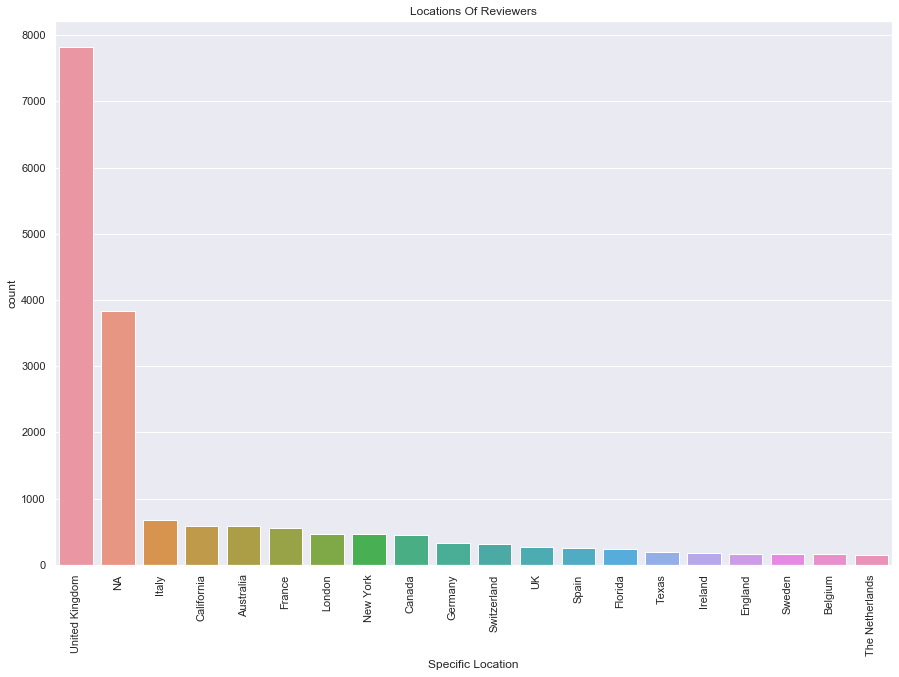

In [11]:
df = df.fillna('NA') # 3,953 NA's in the "Location Of The Reviewer" column, so replace these with the string 'NA' so the following loop doesn't run into an error
specific_locations = []
for i in df['Location Of The Reviewer']:
    if ", " not in i:
        specific_locations.append(i)
    else:
        specific_locations.append(i.rsplit(", ", 1)[1])
df['Specific Location'] = specific_locations

grid = sb.countplot(x = 'Specific Location', data = df, order = df['Specific Location'].value_counts().iloc[:20].index)
grid.set_title('Locations Of Reviewers')
grid.set_xticklabels(grid.get_xticklabels(), rotation=90)

The final graph will be looking at the number of reviews given for each year, which will be the last 4 characters of the "Date Of Review" column. 

[Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '2018')]

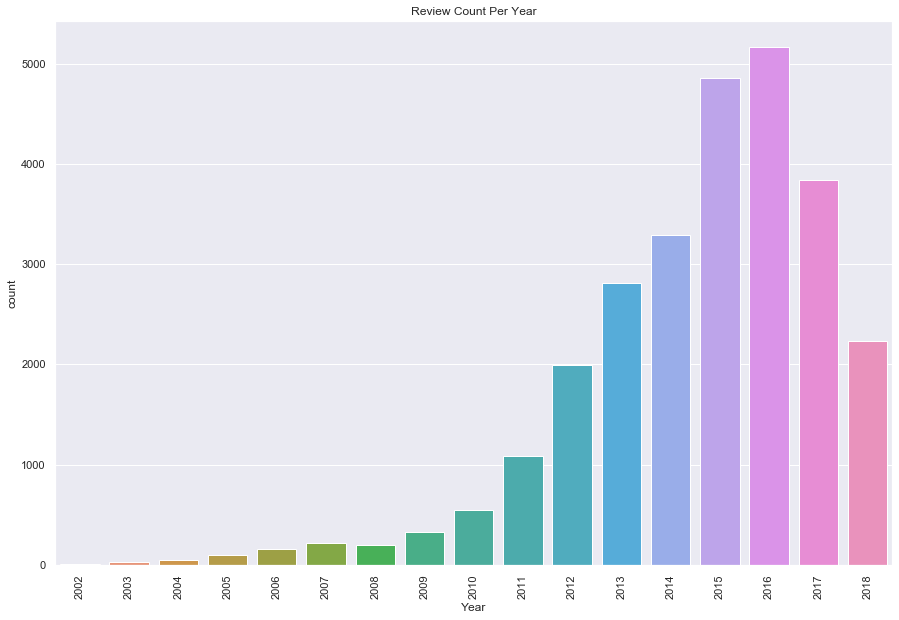

In [12]:
years = []
for i in df['Date Of Review']:
    years.append(i[-4:])
df['Year'] = years
grid = sb.countplot(x = 'Year', data = df)
grid.set_title('Review Count Per Year')
grid.set_xticklabels(grid.get_xticklabels(), rotation=90)

### Sentiment Analysis

Now that we have a good handle on the data, we can try to make a simple model that can take the text of a review and predict from that what rating was given. To keep it simple for the model I'll divide reviews into good and bad, with "good" being a 5 star review and bad being anything below. 

In [13]:
df['Complete Review'] = df['Review Title'] + ' ' + df['Review Text']
df.loc[df['Review Rating'] > 4, 'Good Review'] = 1
df.loc[df['Review Rating'] <= 4, 'Good Review'] = 0
print(sum(df['Good Review'] == 0) / len(df['Good Review']) * 100, 'percent of reviews are bad (less than 5 star).')

32.874828060522695 percent of reviews are bad (less than 5 star).


Next to make a train and test set, with 80% of the data being the train set and 20% being the test set. The model will be trained on the training data and evaluated on the test data.

In [14]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

Before feeding reviews into a model, they should be cleaned to remove punctuation, as that willl be useless from the computers point of view in trying to work out the sentiment of a text - for this case we're only interested in the words in a review. The code below (from https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184) gets rid of punctuation so a review is turned into words only.

In [15]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(train['Complete Review'])
reviews_test_clean = preprocess_reviews(test['Complete Review'])

The next step is *one hot encoding*, where we turn each review into a very large matrix of 0's and 1's. A 0 would represent a certain word isn't included, whereas a 1 means that word is included. A short review of a few words would have a matrix of almost entirely 0's (ie. the vast majority of unique words across all reviews aren't present in the review), with just a small number of 1's. This is necessary for the logistic regression algorithm used below.

In [16]:
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X_train = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

Now we can finally train a model on the train data with model.fit(). After that, model.predict() can be called on the test data to evaluate how good the model does. We know around 67% of reviews are 5 stars, so as a naive benchmark, we'd expect the model to predict the right rating based on the review text over 67% of the time.

In [17]:
target_train = train['Good Review']
target_test = test['Good Review']

model = LogisticRegression()
model.fit(X_train, target_train)
print ("Accuracy: %s" % accuracy_score(target_test, model.predict(X_test)))

Accuracy: 0.8105710589539826


C:\Users\vitaly2\AppData\Local\conda\conda\envs\cse6240v1\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


With over 80% accuracy, this is a reasonable model in that it clearly beats the naive baseline that merely guesses the most likely rating (5 stars - good) for each review, though it could be improved as I haven't done any tweaking.

Finally, it's interesting to see what words the model considers good and bad, 

In [18]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), model.coef_[0]
    )
}
print('Good words:', end = "\n\n")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
print('')
print('Bad words:', end = "\n\n")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

Good words:

('pancras', 1.6043071233417219)
('soak', 1.585352176522113)
('magnificent', 1.4817986616702465)
('speaking', 1.456538251615262)
('lcd', 1.417971645707876)

Bad words:

('lacking', -1.7424302867572528)
('festive', -1.703789205824328)
('lacked', -1.641935004096973)
('disappointing', -1.6285308745409788)
('likely', -1.612314928013726)


Some of the words the model considers good and bad are a bit strange, so it's clear there's room for improvement :)

Comments/feedback welcome.